# 7.5.MobileNetV2_from_Scratch_training_(20,50,200)_labels_1000_epochs

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Creando el modelo

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from imutils import paths
import numpy as np
import os

In [3]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNetV2'

In [4]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['20', '200', '50', 'unknown']
codificando etiquetas
[0 1 2 3]


In [5]:
input_shape = (img_size, img_size, 3)
base_model = MobileNetV2(
                    #include_top=True,
                    include_top=False,
                    #weights=None,
                    weights='imagenet',
                    input_shape=input_shape,
                    #pooling='max',
                    #classes=len(classNames_ids),
                    #classifier_activation='softmax'
                   )

In [6]:
for layer in base_model.layers:
    layer.trainable = True

In [7]:
model = tf.keras.Sequential([base_model,
                             Flatten(),
                             Dense(len(classNames_ids), activation='softmax')
                            ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 250884    
Total params: 2,508,868
Trainable params: 2,474,756
Non-trainable params: 34,112
_________________________________________________________________


# Entrenamiento

In [9]:
batch_size = 64

In [10]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='training')
validation_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='validation')

Found 7527 images belonging to 4 classes.
Found 1881 images belonging to 4 classes.


In [11]:
optimizer = SGD(learning_rate=0.0001, momentum=0.9)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [12]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [13]:
# load weigths
better_checkpoint = 'epoch-975-val_loss:0.0075-val_accuracy:0.9979.hdf5'
model.load_weights(path_checkpoints + '/' + better_checkpoint)

In [ ]:
epochs = 1000

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

# Gráfica

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Testing model

In [14]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt

In [15]:
models = [model]

INFO:tensorflow:Load image with size: 2671, num_label: 4, labels: 20, 200, 50, unknown.


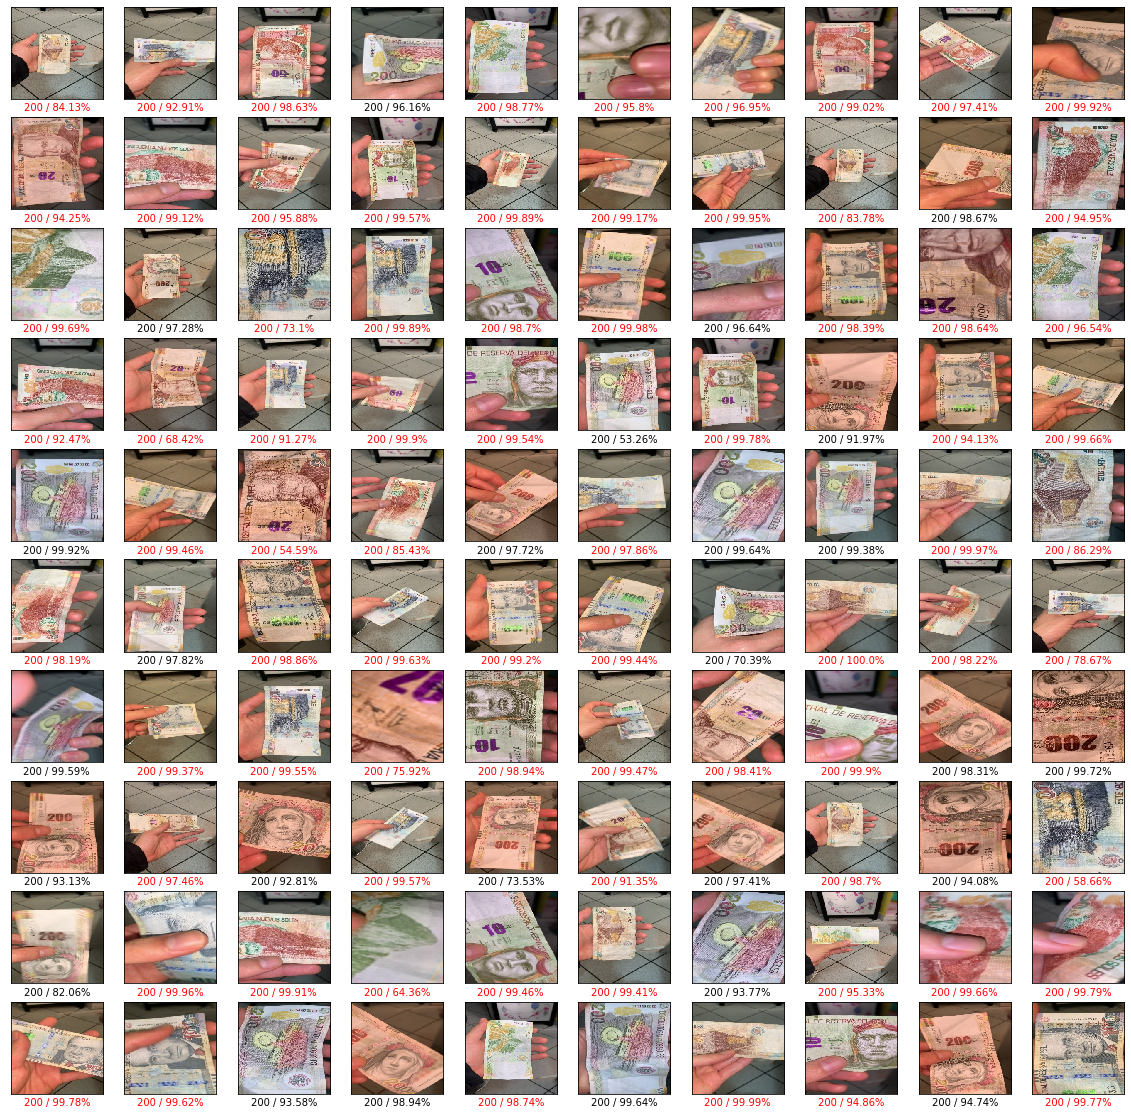

In [16]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    #predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    
    #utilizando el average de los modelos para la predicción
    predictions = []
    #counter = 0
    for model in models:
        #if counter == 0:
        #    print('==========')
        #if counter > 2:
        #    counter = 0
        #print(np.argmax(model.predict(arr4d)))
        #print(classNames[np.argmax(model.predict(arr4d))])
        predictions.append(model.predict(arr4d))
        #counter += 1
    #print(predictions)
    #print('==')
    prediction_average = np.average(predictions, axis=0)
    id_predict = np.argmax(prediction_average)
    percentage = round(prediction_average[0][id_predict] * 100, 2)
    predict_label = classNames[id_predict]
    
    #print(prediction_average * 100)
    #print(id_predict)
    #print('==============')
    
    #setup color
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    image_label = predict_label + ' / ' + str(percentage) + '%'
    plt.xlabel(image_label)
plt.show()